# Forward Process DDPM
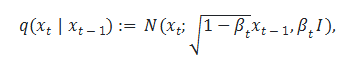
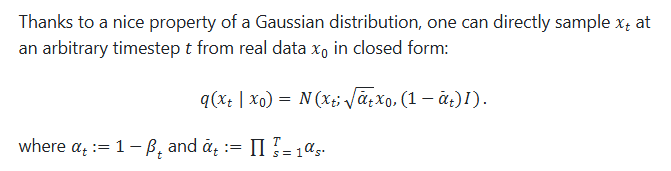

# Forward Process DDIM
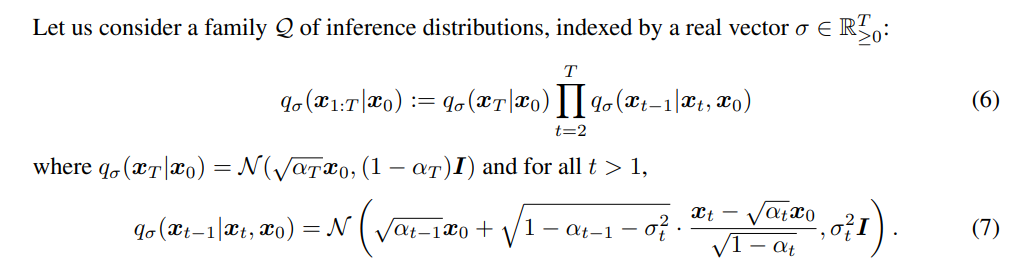

# Reverse Process DDPM
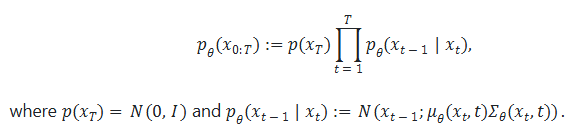

# Reverse Process DDIM
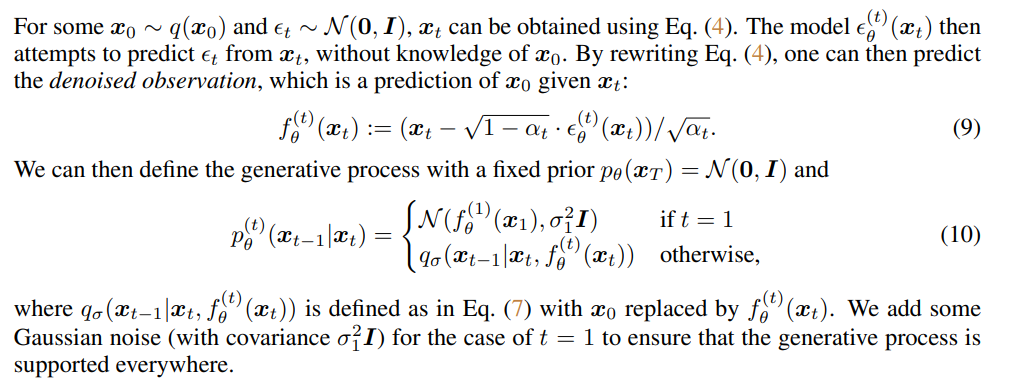

# Training LOSS DDPM 
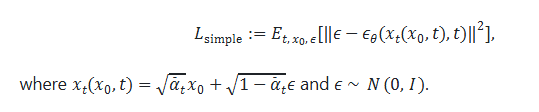

# Training Loss DDIM
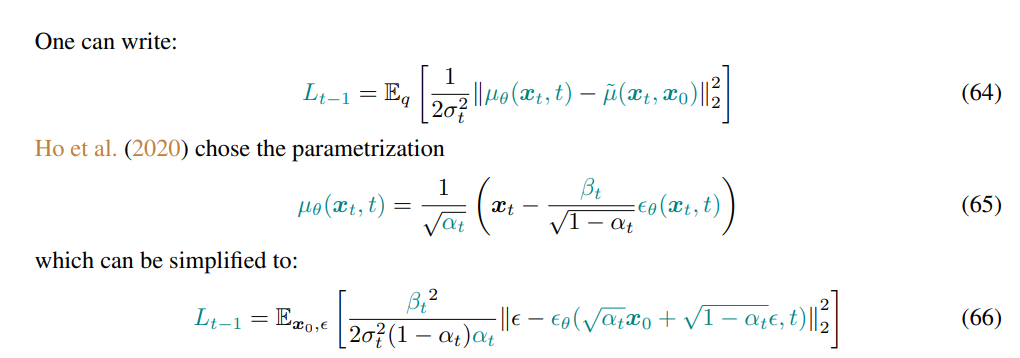

# DDPM Sampling
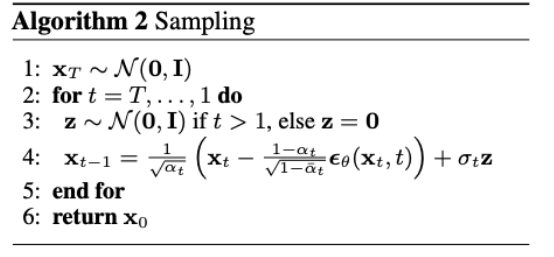

# DDIM Sampling
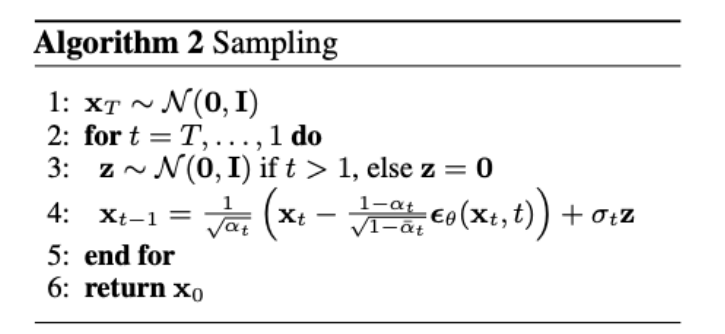
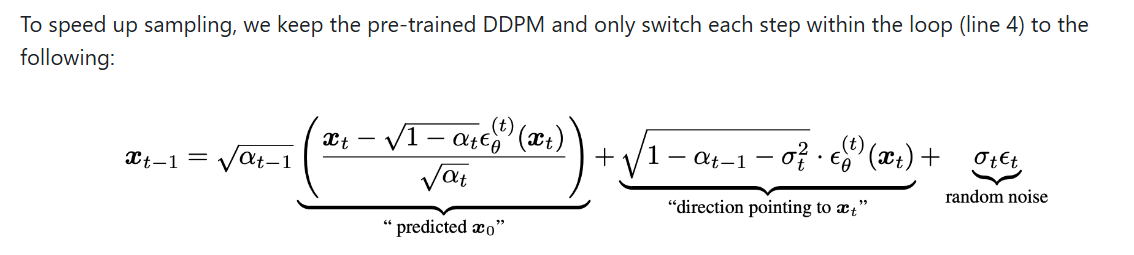
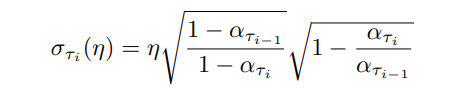

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


from IPython.display import display, clear_output
from PIL import Image
import io
import math
from typing import List
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist


from ipywidgets import interact, IntSlider, Output
from tqdm import tqdm
from sklearn import datasets

In [37]:
# %load_ext autoreload
# %autoreload 2

# Dataset

In [38]:
def normalize(ds, scaling_factor=2.0):
    return (ds - ds.mean()) / ds.std() * scaling_factor


def sample_checkerboard(n):
    # https://github.com/ghliu/SB-FBSDE/blob/main/data.py
    n_points = 3 * n
    n_classes = 2
    freq = 5
    x = np.random.uniform(
        -(freq // 2) * np.pi, (freq // 2) * np.pi, size=(n_points, n_classes)
    )
    mask = np.logical_or(
        np.logical_and(np.sin(x[:, 0]) > 0.0, np.sin(x[:, 1]) > 0.0),
        np.logical_and(np.sin(x[:, 0]) < 0.0, np.sin(x[:, 1]) < 0.0),
    )
    y = np.eye(n_classes)[1 * mask]
    x0 = x[:, 0] * y[:, 0]
    x1 = x[:, 1] * y[:, 0]
    sample = np.concatenate([x0[..., None], x1[..., None]], axis=-1)
    sqr = np.sum(np.square(sample), axis=-1)
    idxs = np.where(sqr == 0)
    sample = np.delete(sample, idxs, axis=0)

    return sample




In [39]:
def load_twodim(num_samples: int, dataset: str, dimension: int = 2):

    if dataset == "gaussian_centered":
        sample = np.random.normal(size=(num_samples, dimension))
        sample = sample

    if dataset == "gaussian_shift":
        sample = np.random.normal(size=(num_samples, dimension))
        sample = sample + 1.5

    if dataset == "circle":
        X, y = datasets.make_circles(
            n_samples=num_samples, noise=0.0, random_state=None, factor=0.5
        )
        sample = X * 4

    if dataset == "scurve":
        X, y = datasets.make_s_curve(
            n_samples=num_samples, noise=0.0, random_state=None
        )
        sample = normalize(X[:, [0, 2]])

    if dataset == "moon":
        X, y = datasets.make_moons(n_samples=num_samples, noise=0.0, random_state=None)
        sample = normalize(X)

    if dataset == "swiss_roll":
        X, y = datasets.make_swiss_roll(
            n_samples=num_samples, noise=0.0, random_state=None, hole=True
        )
        sample = normalize(X[:, [0, 2]])

    if dataset == "checkerboard":
        sample = normalize(sample_checkerboard(num_samples))

    return torch.tensor(sample).float()


In [40]:
class TwoDimDataClass(Dataset):
    def __init__(self, dataset_type: str, N: int, batch_size: int, dimension=2):

        self.X = load_twodim(N, dataset_type, dimension=dimension)
        self.name = dataset_type
        self.batch_size = batch_size
        self.dimension = 2

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]

    def get_dataloader(self, shuffle=True):
        return DataLoader(
            self,
            batch_size=self.batch_size,
            shuffle=shuffle,
            pin_memory=True,
        )

In [41]:
def get_data_iterator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

# Visualize target and prior distributions

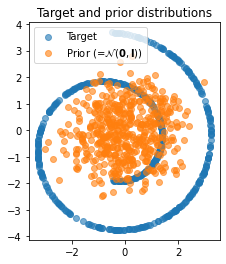

In [42]:
target_ds = TwoDimDataClass(dataset_type='swiss_roll', 
                            N=1000000, 
                            batch_size=256)

prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=1000000,
                           batch_size=256)

num_vis_particles = 500
sample_f = target_ds[0:num_vis_particles]
sample_b = prior_ds[0:num_vis_particles]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and prior distributions"
ax.set_title(strtitle)
ax.legend(['Target', 'Prior (=$\mathcal{N}(\mathbf{0}, \mathbf{I})$)'])


# Network

In [43]:
class TimeEmbedding(nn.Module):
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
        return embedding

    def forward(self, t: torch.Tensor):
        if t.ndim == 0:
            t = t.unsqueeze(-1)
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb

In [44]:
class TimeLinear(nn.Module):
    def __init__(self, dim_in: int, dim_out: int, num_timesteps: int):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.num_timesteps = num_timesteps

        self.time_embedding = TimeEmbedding(dim_out)
        self.fc = nn.Linear(dim_in, dim_out)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.fc(x)
        alpha = self.time_embedding(t).view(-1, self.dim_out)

        return alpha * x

### 1-1: Build a noise prediction network
Design a network that takes
- Noisy data 𝒙_𝑡;
- Current diffusion timestep 𝑡
- Modify SimpleNet to consist of "TimeLinear layers" whose feature dimensions are a sequence of:
    - [dim_in, dim_hids[0], ..., dim_hids[-1], dim_out]. 
- Every "TimeLinear layer" except for the last TimeLinear layer should be followed by a ReLU activation.


In [45]:
class SimpleNet(nn.Module):
    def __init__(
        self, dim_in: int, dim_out: int, dim_hids: List[int], num_timesteps: int
    ):
        super().__init__()
        """
        (TODO) Build a noise estimating network.

        Args:
            dim_in: dimension of input
            dim_out: dimension of output
            dim_hids: dimensions of hidden features
            num_timesteps: number of timesteps
        """

        ######## TODO ########
        self.dim_in         = dim_in
        self.dim_out        = dim_out
        self.num_timesteps  = num_timesteps
        self.dim_hids       = dim_hids
        
        # To hold layers in a list
        layers = []
        
        # Input layer
        layers.append(TimeLinear(self.dim_in, self.dim_hids[0], self.num_timesteps))
        layers.append(nn.ReLU())
        
        # Hidden Layers
        for i in range(len(self.dim_hids) - 1):
            layers.append(TimeLinear(self.dim_hids[i], self.dim_hids[i], self.num_timesteps))
            layers.append(nn.ReLU())
            
        # Output Layer
        layers.append(TimeLinear(self.dim_hids[-1], self.dim_out, self.num_timesteps))

        # create sequential model to apply layers
        self.model = nn.Sequential(*layers)
        
        ######################
        
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        (TODO) Implement the forward pass. This should output
        the noise prediction of the noisy input x at timestep t.

        Args:
            x: the noisy data after t period diffusion
            t: the time that the forward diffusion has been running
        """
        ######## TODO ########
        for layer in self.model:
            if isinstance(layer, TimeLinear):
                x = layer(x, t)
            else:
                x = layer(x)
                
        ######################
        return x

In [46]:
def test_simplenet():
    # Parameters for the test
    dim_in = 2          # Input feature dimension
    dim_out = 2         # Output feature dimension
    dim_hids = [128, 128, 128] # Hidden layer dimensions
    num_timesteps = 1000 # Number of timesteps
    batch_size = 8       # Batch size for testing

    # Dummy data for testing
    x = torch.randn(batch_size, dim_in)  # Random input data
    t = torch.randint(0, num_timesteps, (batch_size,))  # Random timesteps

    # Initialize the network
    model = SimpleNet(dim_in=dim_in, dim_out=dim_out, dim_hids=dim_hids, num_timesteps=num_timesteps)

    # Print model structure (optional)
    print(model)

    # Run the forward pass
    output = model(x, t)

    # Assertions to verify the output
    assert output.shape == (batch_size, dim_out), f"Expected output shape {(batch_size, dim_out)}, got {output.shape}"

    # Debug output
    print(f"Input shape: {x.shape}")
    print(f"Timestep shape: {t.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Output: {output}")

# Run the test
test_simplenet()


SimpleNet(
  (model): Sequential(
    (0): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=128, bias=True)
          (1): SiLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
      )
      (fc): Linear(in_features=2, out_features=128, bias=True)
    )
    (1): ReLU()
    (2): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=128, bias=True)
          (1): SiLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
      )
      (fc): Linear(in_features=128, out_features=128, bias=True)
    )
    (3): ReLU()
    (4): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=128, bias=True)
          (1): SiLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
      )
     

# DDPM

In [47]:
class BaseScheduler(nn.Module):
    """
    Variance scheduler of DDPM.
    """

    def __init__(
        self,
        num_train_timesteps: int,
        beta_1: float = 1e-4,
        beta_T: float = 0.02,
        mode: str = "linear",
    ):
        super().__init__()
        self.num_train_timesteps = num_train_timesteps
        self.timesteps = torch.from_numpy(
            np.arange(0, self.num_train_timesteps)[::-1].copy().astype(np.int64)
        )

        if mode == "linear":
            betas = torch.linspace(beta_1, beta_T, steps=num_train_timesteps)
        elif mode == "quad":
            betas = (
                torch.linspace(beta_1**0.5, beta_T**0.5, num_train_timesteps) ** 2
            )
        else:
            raise NotImplementedError(f"{mode} is not implemented.")

        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)

In [48]:
def extract(input, t: torch.Tensor, x: torch.Tensor):
    if t.ndim == 0:
        t = t.unsqueeze(0)
    shape = x.shape
    t = t.long().to(input.device)
    out = torch.gather(input, 0, t)
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)


### Forward
- q_sample() is a forward function that maps 
    - x0 to xt
### Reverse
- p_sample() is a one-step reverse transition from 
    - xt to xt−1
 - p_sample_loop() is the full reverse process corresponding to DDPM sampling algorithm

In [92]:
class DiffusionModule(nn.Module):
    """
    A high-level wrapper of DDPM and DDIM.
    If you want to sample data based on the DDIM's reverse process, use `ddim_p_sample()` and `ddim_p_sample_loop()`.
    """

    def __init__(self, network: nn.Module, var_scheduler: BaseScheduler):
        super().__init__()
        self.network = network
        self.var_scheduler = var_scheduler

    @property
    def device(self):
        return next(self.network.parameters()).device

    @property
    def image_resolution(self):
        # For image diffusion model.
        return getattr(self.network, "image_resolution", None)

    def q_sample(self, x0, t, noise=None):
        """
        sample x_t from q(x_t | x_0) of DDPM.

        Input:
            x0 (`torch.Tensor`): clean data to be mapped to timestep t in the forward process of DDPM.
            t (`torch.Tensor`): timestep
            noise (`torch.Tensor`, optional): random Gaussian noise. if None, randomly sample Gaussian noise in the function.
        Output:
            xt (`torch.Tensor`): noisy samples
        """
        if noise is None:
            noise = torch.randn_like(x0)

        ######## TODO ########
        # DO NOT change the code outside this part.
        # Compute xt.
        alphas_prod_t = extract(self.var_scheduler.alphas_cumprod, t, x0)
        xt = alphas_prod_t.sqrt()*x0 + (1-alphas_prod_t).sqrt()*noise

        #######################

        return xt

    @torch.no_grad()
    def p_sample(self, xt, t):
        """
        One step denoising function of DDPM: x_t -> x_{t-1}.

        Input:
            xt (`torch.Tensor`): samples at arbitrary timestep t.
            t (`torch.Tensor`): current timestep in a reverse process.
        Ouptut:
            x_t_prev (`torch.Tensor`): one step denoised sample. (= x_{t-1})

        """
        ######## TODO ########
        # DO NOT change the code outside this part.
        # compute x_t_prev.
        if isinstance(t, int):
            t = torch.tensor([t]).to(self.device)
            # t = torch.full((xt.shape[0],), t, device=xt.device, dtype=torch.long)
        
        alpha_t         =   extract(self.var_scheduler.alphas, t, xt)
        alpha_cumprod_t =   extract(self.var_scheduler.alphas_cumprod, t, xt)
        
        
        eps_factor = (1 - alpha_t) / (1 - alpha_cumprod_t).sqrt()
        
        # Predict the noise (epsilon theta)
        eps_theta = self.network(xt, t)

        mean = (xt - eps_factor*eps_theta) / (alpha_t.sqrt())
        
        noise = torch.randn_like(xt) 
        
        x_t_prev = mean + (1-alpha_t).sqrt() * noise

        #######################
        return x_t_prev

    @torch.no_grad()
    def p_sample_loop(self, shape):
        """
        The loop of the reverse process of DDPM.

        Input:
            shape (`Tuple`): The shape of output. e.g., (num particles, 2)
        Output:
            x0_pred (`torch.Tensor`): The final denoised output through the DDPM reverse process.
        """
        ######## TODO ########
        # DO NOT change the code outside this part.
        # sample x0 based on Algorithm 2 of DDPM paper.
        x0_pred = torch.randn(shape).to(self.device)
        T = self.var_scheduler.num_train_timesteps
        
        for time in range(T-1, -1, -1):
            x0_pred = self.p_sample(x0_pred, time)

        
        # for t in reversed(range(self.var_scheduler.num_train_timesteps)):

        #     time_tensor = torch.full((shape[0],), t, device=self.device, dtype=torch.long)

        #     x0_pred = self.p_sample(x0_pred, time_tensor)
        ######################
        return x0_pred

    @torch.no_grad()
    def ddim_p_sample(self, xt, t, t_prev, eta=0.0):
        """
        One step denoising function of DDIM: $x_t{\tau_i}$ -> $x_{\tau{i-1}}$.

        Input:
            xt (`torch.Tensor`): noisy data at timestep $\tau_i$.
            t (`torch.Tensor`): current timestep (=\tau_i)
            t_prev (`torch.Tensor`): next timestep in a reverse process (=\tau_{i-1})
            eta (float): correspond to η in DDIM which controls the stochasticity of a reverse process.
        Output:
           x_t_prev (`torch.Tensor`): one step denoised sample. (= $x_{\tau_{i-1}}$)
        """
        ######## TODO ########
        # NOTE: This code is used for assignment 2. You don't need to implement this part for assignment 1.
        # DO NOT change the code outside this part.
        # compute x_t_prev based on ddim reverse process.
        xt = xt.to(self.device)
        t = t.to(self.device)
        t_prev = t_prev.to(self.device)

        alpha_prod_t = extract(self.var_scheduler.alphas_cumprod, t, xt)
        beta_t = extract(self.var_scheduler.betas, t, xt)
        if t_prev >= 0:
            alpha_prod_t_prev = extract(self.var_scheduler.alphas_cumprod, t_prev, xt)
        else:
            alpha_prod_t_prev = torch.ones_like(alpha_prod_t)

        eps_theta   = self.network(xt, t)
        sigma       = ((1-alpha_prod_t_prev)/(1-alpha_prod_t)*beta_t).sqrt() * eta
        noise       = torch.randn_like(xt) if t > 1 else torch.zeros_like(xt)

        predicted_x0 = (alpha_prod_t_prev).sqrt() * (xt - (1-alpha_prod_t).sqrt() * eps_theta) / (alpha_prod_t.sqrt())
        
        direction_pointing_to_xt = (1-alpha_prod_t_prev-sigma.square()).sqrt() * eps_theta
        
        random_noise = sigma * noise

        x_t_prev = predicted_x0 + direction_pointing_to_xt + random_noise

        ######################
        return x_t_prev

    @torch.no_grad()
    def ddim_p_sample_loop(self, shape, num_inference_timesteps=50, eta=0.0):
        """
        The loop of the reverse process of DDIM.

        Input:
            shape (`Tuple`): The shape of output. e.g., (num particles, 2)
            num_inference_timesteps (`int`): the number of timesteps in the reverse process.
            eta (`float`): correspond to η in DDIM which controls the stochasticity of a reverse process.
        Output:
            x0_pred (`torch.Tensor`): The final denoised output through the DDPM reverse process.
        """
        ######## TODO ########
        # NOTE: This code is used for assignment 2. You don't need to implement this part for assignment 1.
        # DO NOT change the code outside this part.
        # sample x0 based on Algorithm 2 of DDPM paper.
        step_ratio = self.var_scheduler.num_train_timesteps // num_inference_timesteps
        timesteps = (
            (np.arange(0, num_inference_timesteps) * step_ratio)
            .round()[::-1]
            .copy()
            .astype(np.int64)
        )
        timesteps = torch.from_numpy(timesteps)
        prev_timesteps = timesteps - step_ratio

        xt = torch.randn(shape).to(self.device)
        for t, t_prev in zip(timesteps, prev_timesteps):
            xt = self.ddim_p_sample(xt, t, t_prev, eta)

        x0_pred = xt

        ######################

        return x0_pred

    def compute_loss(self, x0):
        """
        The simplified noise matching loss corresponding Equation 14 in DDPM paper.

        Input:
            x0 (`torch.Tensor`): clean data
        Output:
            loss: the computed loss to be backpropagated.
        """
        ######## TODO ########
        # DO NOT change the code outside this part.
        # compute noise matching loss.
        batch_size = x0.shape[0]
        t = (
            torch.randint(0, self.var_scheduler.num_train_timesteps, size=(batch_size,))
            .to(x0.device)
            .long()
        )
        noise = torch.randn_like(x0) #if t > 1 else 0
        # alpha_cumprod_t =   extract(self.var_scheduler.alphas_cumprod, t, x0)
        # x_noise = (alpha_cumprod_t.sqrt()*x0 + (1-alpha_cumprod_t).sqrt()*noise)
        x_noise = self.q_sample(x0, t, noise)
        pred_noise = self.network(x_noise, t)

        loss = F.mse_loss(pred_noise, noise)

        ######################
        return loss

    def save(self, file_path):
        hparams = {
            "network": self.network,
            "var_scheduler": self.var_scheduler,
        }
        state_dict = self.state_dict()

        dic = {"hparams": hparams, "state_dict": state_dict}
        torch.save(dic, file_path)

    def load(self, file_path):
        dic = torch.load(file_path, map_location="cpu")
        hparams = dic["hparams"]
        state_dict = dic["state_dict"]

        self.network = hparams["network"]
        self.var_scheduler = hparams["var_scheduler"]

        self.load_state_dict(state_dict)

In [93]:
device="cuda"
config = {
    "num_diffusion_steps": 1000,
    "dim_hids": [128, 128, 128],
    "lr": 1e-3,
    "batch_size": 128,
    "num_train_iters": 5000,
    "device": device,
}
var_scheduler = BaseScheduler(config["num_diffusion_steps"])
train_dl = torch.utils.data.DataLoader(target_ds, batch_size=config["batch_size"])
train_iter = get_data_iterator(train_dl)
batch_x = next(train_iter)
batch_size = batch_x.shape[0]
print("batch size= ",batch_size)
print("range from 0 to",var_scheduler.num_train_timesteps)
t = (
    torch.randint(0, var_scheduler.num_train_timesteps, size=(batch_size,))
    .long()
)
t

batch size=  128
range from 0 to 1000


tensor([554, 934, 694, 666, 991, 825,  37, 708, 305, 561, 879, 298, 300, 432,
        878,  39, 925, 512, 493, 302,  31, 364, 705, 297, 209, 128,  77, 856,
        706, 289, 709, 448, 553, 516, 970, 888, 159, 975, 172, 331, 811, 899,
        929,  21, 562,  59, 509, 435, 244, 504, 237, 551, 476,  26, 214, 886,
        626, 819, 198, 823, 712, 266, 992, 644, 940, 396, 249, 911, 990,  87,
        894, 923,  88, 509, 387, 148, 209, 898, 529, 195, 674, 160, 185, 472,
        771, 658, 644, 619, 673, 464, 888, 388, 675, 741, 851, 224, 929, 597,
         91, 570, 378, 234, 959, 246, 236, 172, 202, 988, 802, 395, 729, 231,
        298, 808, 589, 645, 415, 413, 121, 415, 954, 144, 132, 940, 213, 469,
        370, 420])

# Define a Diffusion Model

In [94]:
# hyperparameters #
# Don't change it
device = "cuda"
config = {
    "num_diffusion_steps": 1000,
    "dim_hids": [128, 128, 128],
    "lr": 1e-3,
    "batch_size": 128,
    "num_train_iters": 5000,
    "device": device,
}

###################

def build_ddpm(config):
    network = SimpleNet(dim_in=2, 
                        dim_out=2, 
                        dim_hids=config["dim_hids"], 
                        num_timesteps=config["num_diffusion_steps"]
                       )
    var_scheduler = BaseScheduler(config["num_diffusion_steps"])

    ddpm = DiffusionModule(network, var_scheduler).to(config["device"])
    return ddpm

ddpm = build_ddpm(config)


# Visualize q(x_t)

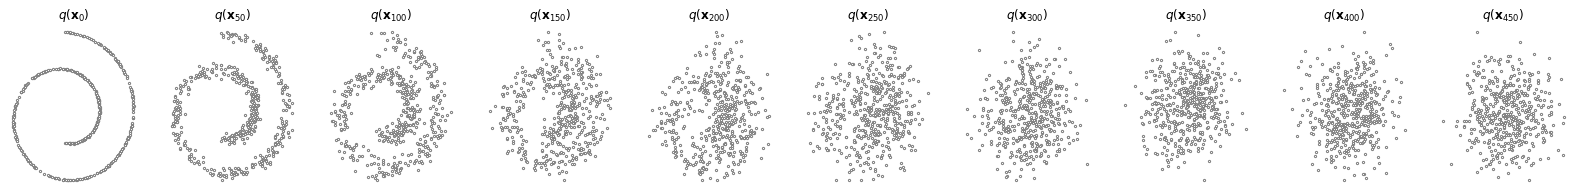

In [95]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i, t in enumerate(range(0, 500, 50)):
    x_t = ddpm.q_sample(target_ds[:num_vis_particles].to(device), (torch.ones(num_vis_particles) * t).to(device))
    x_t = x_t.cpu()
    axs[i].scatter(x_t[:,0], x_t[:,1], color='white',edgecolor='gray', s=5)
    axs[i].set_axis_off()
    axs[i].set_title('$q(\mathbf{x}_{'+str(t)+'})$')

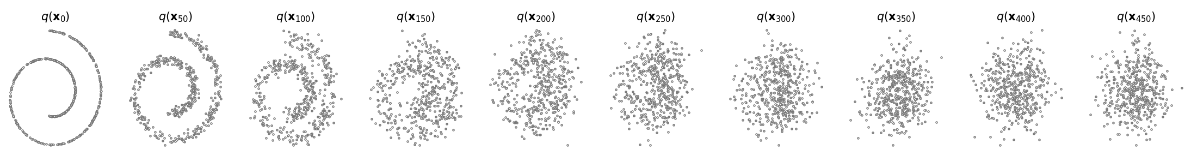

In [96]:
# You should be able to see the distributions as below.
vis_qs = Image.open("assets/images/qs.png")
display(vis_qs)

# Dataset

In [97]:
def get_data_iterator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

# Training


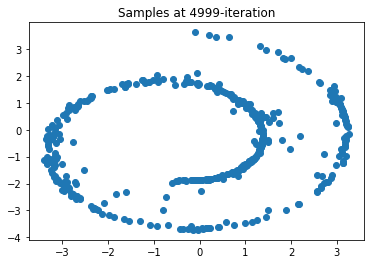

loss: 0.3397: 100%|██████████| 5000/5000 [00:58<00:00, 85.56it/s]


interactive(children=(IntSlider(value=1, description='index', max=1), Output()), _dom_classes=('widget-interac…

Output()

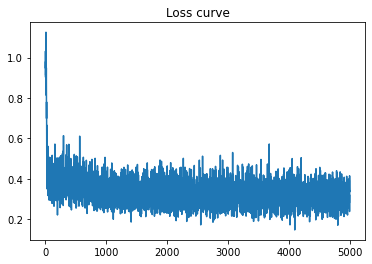

In [98]:
def figure2image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

# Initialize the model.
ddpm = build_ddpm(config)

pbar = tqdm(range(config["num_train_iters"]))
optimizer = torch.optim.Adam(ddpm.parameters(), lr=config["lr"])
train_dl = torch.utils.data.DataLoader(target_ds, batch_size=config["batch_size"])
train_iter = get_data_iterator(train_dl)

losses = []
images = []
try:
    for step in pbar:
        optimizer.zero_grad()
        
        batch_x = next(train_iter)
        batch_x = batch_x.to(device)
        loss = ddpm.compute_loss(batch_x)

        loss.backward()
        optimizer.step()
        pbar.set_description(f"loss: {loss.item():.4f}")
        
        losses.append(loss.item())
        
        if step % 4999 == 0:
            with torch.no_grad():
                ####
                # NOTE: If you haven't implemented the `ddim_p_sample_loop` method,
                # use the `p_sample_loop` method instead.
                #x0 = ddpm.p_sample_loop(shape=(num_vis_particles, 2)).cpu()
                x0 = ddpm.ddim_p_sample_loop(shape=(num_vis_particles, 2)).cpu()
                ####
                fig, ax = plt.subplots(1,1)
                ax.scatter(x0[:,0], x0[:,1])
                ax.set_title(f"Samples at {step}-iteration")
                clear_output(wait=True)
                plt.show()
                img = figure2image(fig)
                images.append(img)
                
except KeyboardInterrupt:
    pass
finally:
    if len(images) > 0:
        slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
        output = Output()
        def display_image(index):
            with output:
                output.clear_output(wait=True)
                display(images[index])
        interact(display_image, index=slider)
        display(output)
        plt.plot(losses)
        plt.title("Loss curve")

# Evaluation

### Chamfer Distance

In [99]:
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist

def chamfer_distance(S1, S2) -> float:
    """
    Computes the Chamfer distance between two point clouds defined as:
    d_CD(S1, S2) = \sigma_{x \in S1} min_{y in S2} ||x - y||^2 + \sigma_{y \in S2} min_{x in S1} ||x - y||^2
    """
    dist = cdist(S1, S2)
    dist1 = dist.min(axis=1) ** 2
    dist2 = dist.min(axis=0) ** 2
    return dist1.sum() + dist2.sum()

## DDPM sampling 1

DDPM Chamfer Distance: 11.8244


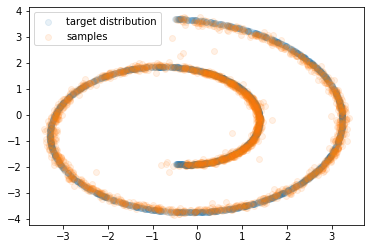

In [100]:

# You will get full credits if your chamfer distance is lower than 20.

num_eval_particles = 2048
pc_ref = target_ds[:num_eval_particles]
pc_gen = ddpm.p_sample_loop(shape=(num_eval_particles, 2))

pc_gen = pc_gen.reshape(1, num_eval_particles, 2)
pc_ref = pc_ref.reshape(1, num_eval_particles, 2)
with torch.no_grad():
    cd = chamfer_distance(
            pc_gen.reshape(-1, 2).cpu().numpy(),
            pc_ref.reshape(-1, 2).cpu().numpy(),
        )
    print(f"DDPM Chamfer Distance: {cd.item():.4f}")

# Visualize samples with the target distribution.
pc_gen = pc_gen.reshape(num_eval_particles, 2).cpu().numpy()
pc_ref = pc_ref.reshape(num_eval_particles, 2).cpu().numpy()

fig, ax = plt.subplots(1,1)
ax.scatter(pc_ref[:,0], pc_ref[:,1], alpha=0.1, label="target distribution")
ax.scatter(pc_gen[:,0], pc_gen[:,1], alpha=0.1, label="samples")
ax.legend()
plt.show()


## DDIM sampling 2

DDIM Chamfer Distance: 34.9708


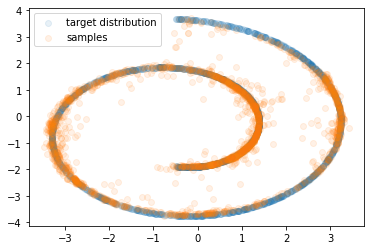

In [101]:
# You will get full credits if your chamfer distance is lower than 40.

num_eval_particles = 2048
pc_ref = target_ds[:num_eval_particles]
pc_gen = ddpm.ddim_p_sample_loop(shape=(num_eval_particles, 2))

pc_gen = pc_gen.reshape(1, num_eval_particles, 2)
pc_ref = pc_ref.reshape(1, num_eval_particles, 2)
with torch.no_grad():
    cd = chamfer_distance(
            pc_gen.reshape(-1, 2).cpu().numpy(),
            pc_ref.reshape(-1, 2).cpu().numpy(),
        )
    print(f"DDIM Chamfer Distance: {cd.item():.4f}")
    
# Visualize samples with the target distribution.
pc_gen = pc_gen.reshape(num_eval_particles, 2).cpu().numpy()
pc_ref = pc_ref.reshape(num_eval_particles, 2).cpu().numpy()

fig, ax = plt.subplots(1,1)
ax.scatter(pc_ref[:,0], pc_ref[:,1], alpha=0.1, label="target distribution")
ax.scatter(pc_gen[:,0], pc_gen[:,1], alpha=0.1, label="samples")
ax.legend()
plt.show()
